# 時系列データの記述・処理

In [57]:
# パッケージのインストール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 移動平均(時系列変動の平滑化)

- ウィンドウサイズnによって平均を取って平滑化する **移動平均法(running median method)** 
- データはみずほ銀行の外国為替相場のヒストリカルデータを使用する。
    - https://www.mizuhobank.co.jp/market/historical.html

In [58]:
df_historical = pd.read_csv("./data/m_quote.csv", header=1, encoding="shift-jis")
df_historical.head()

,Unnamed: 0,USD,GBP,EUR,CAD,CHF,SEK,DKK,NOK,AUD,...,HUF,CZK,PLN,RUB,TRY,IDR(100).1,CNY.1,MYR.1,KRW(100).1,TWD
0,2002/4/30,131.15,189.01,115.97,82.83,79.13,12.73,15.61,15.20,70.24,...,*****,*****,*****,NaN,NaN,1.39,15.84,*****,9.99,3.77
1,2002/5/31,126.44,184.56,115.88,81.58,79.60,12.57,15.59,15.43,69.58,...,*****,*****,*****,NaN,NaN,1.41,15.28,*****,10.10,3.68
2,2002/6/28,123.53,183.00,117.83,80.64,80.09,12.94,15.86,15.92,70.29,...,*****,*****,*****,NaN,NaN,1.44,14.93,*****,10.20,3.66
3,2002/7/31,118.05,183.64,117.23,76.52,80.16,12.67,15.79,15.83,65.42,...,*****,*****,*****,NaN,NaN,1.34,14.26,*****,9.98,3.56
4,2002/8/30,119.08,183.14,116.45,75.85,79.60,12.59,15.69,15.68,64.47,...,*****,*****,*****,NaN,NaN,1.35,14.39,*****,9.97,3.53


2002/4/30からの月次データが格納されていることがわかる

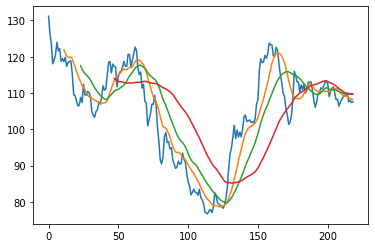

In [59]:
# 原系列データ
df_historical.USD.plot()

# 移動平均(12か月)
df_historical.USD.rolling(window=12).mean().plot()

# 移動平均(24か月)
df_historical.USD.rolling(window=24).mean().plot()

# 移動平均(48か月)
df_historical.USD.rolling(window=48).mean().plot()

- 移動平均をとることで原系列データの変動パターンから季節変動の影響を取り除いた時系列データが作成できる。
- ウィンドウサイズには変動周期に合わせたサイズをとる。
- ウィンドウサイズが12か月の場合:
    - 1月～12月の移動平均をとると、6.5月時点に対応する。
    - 2月～1月(翌年)の移動平均だと、7.5月時点に対応する。
        - **中心化移動平均(CMA: centerd moving average)** 7月時点に対応する系列を求めるためには、6.5月時点と7.5月時点に対応する2点の平均をとる必要がある。

## 中心化移動平均CMA

- 2003年から2012年における月ごとのアイスクリームの家庭平均消費額データを例とする

In [60]:
df_ice = pd.read_csv("./data/icecream.csv", encoding="shift-jis", header=1)
# データの変換
df_ice = df_ice.rename(columns={"年":"year", "月":"month", "アイスクリーム":"expenditure_yen"})
df_ice

,year,month,expenditure_yen
0,2003,1,331
1,2003,2,268
2,2003,3,365
3,2003,4,492
4,2003,5,632
...,...,...,...
115,2012,8,1332
116,2012,9,849
117,2012,10,515
118,2012,11,326


2003年から2012年の月ごとのアイスクリームの消費金額が格納されている。

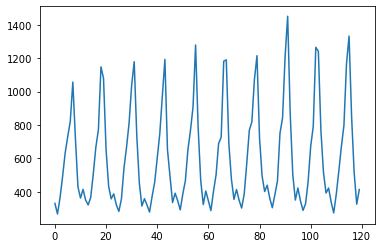

In [61]:
# データのプロット
df_ice.expenditure_yen.plot()

In [62]:
# 12か月で移動平均
# shift(-6)で全体をインデックスの若い方向に6要素ずらしている
df_ma = df_ice.expenditure_yen.rolling(window=12).mean().shift(-6)
# 中心化移動平均
# 更に2つの平均をとる
df_cma = df_ma.rolling(window=2).mean()

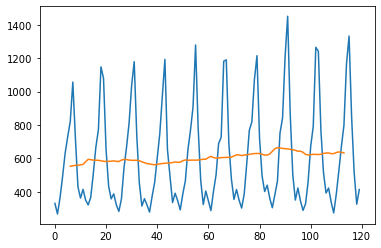

In [63]:
df_ice.expenditure_yen.plot()
# df_ma.plot()
df_cma.plot()

In [64]:
df_ma.head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5     552.333333
6     554.000000
7     558.500000
8     558.666667
9     560.000000
10    562.916667
11    566.416667
12    593.666667
13    595.583333
14    589.666667
15    590.000000
16    589.583333
17    587.333333
18    585.000000
19    581.750000
Name: expenditure_yen, dtype: float64

In [65]:
df_cma.head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     553.166667
7     556.250000
8     558.583333
9     559.333333
10    561.458333
11    564.666667
12    580.041667
13    594.625000
14    592.625000
15    589.833333
16    589.791667
17    588.458333
18    586.166667
19    583.375000
Name: expenditure_yen, dtype: float64

## 季節調整

- 季節パターンがある場合、データからトレンドを読むためには季節パターンの影響を取り除きたい。  
- 季節変動を除去することを **季節調整(seasonal adjustment)** と呼び、その系列のことを季節調整済み系列と呼ぶ。

原系列を傾向変動(T)、季節変動(S)、不規則変動(I)の3つの基本成分の乗法モデルだと考えたときに、  
S成分のみを除いたTxI系列を季節調整済み系列として作成する。

1. 中心化移動平均を求める: T系列の作成
2. 原系列を中心化移動平均で除した値を求め、100倍する: S x I系列の作成(100を1年の平均だとざっくりみている)
3. SxI系列から12か月ごとの季節指数を求める。月ごとの平均値を求めた上でその和が1200になるよう調整する: S系列の作成(100を1年の平均だとみて、12年ぶんあるので1200になるはずとしている)
4. 原系列を季節指数で割って100をかけ、季節調整済みの値とする: T x I系列の作成

In [66]:
# 原系列(アイスクリーム)df_ice.expenditure_yen / 中心化移動平均系列(df_cma)
df_orig_div_cma = df_ice.expenditure_yen / df_cma

# 月ごとに加算
orig_div_cma = df_orig_div_cma.values
s_index = np.zeros(12)
counter = np.zeros(12, dtype='i')
for idx in range(len(orig_div_cma)//12):
    # 12か月ごとにデータを抽出
    # print(idx)
    cut_orig_div_cma = orig_div_cma[idx*12:(idx+1)*12]
    # print(cut_orig_div_cma)
    mask = cut_orig_div_cma!=cut_orig_div_cma
    # print(mask)
    # numpy.whereを使用して非数(NaN)を0にして加算
    counter += np.where(mask, 0, 1)
    s_index += np.where(mask, 0, cut_orig_div_cma)
    # print(counter)
    # print(s_index)
# 加算結果の各月平均
s_index /= counter

# 全体を1200に合わせ季節指数を計算
s_index = s_index / s_index.sum() * 1200

In [67]:
# 季節調整済み系列を計算する
# 原系列のスタートが1月なので、numpy.tileで12か月分の季節指数を繰り返すだけでOK
tiled_s_index = np.tile(s_index, len(orig_div_cma)//12)

df_adjusted_series = df_ice.expenditure_yen / tiled_s_index * 100

In [68]:
s_index

array([ 57.05374632,  48.4935788 ,  61.87100094,  82.34066594,
       112.21945388, 129.50185932, 178.03993789, 201.78512364,
       122.39560152,  79.21403276,  59.2923283 ,  67.79267067])

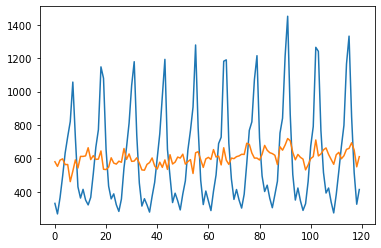

In [69]:
# 図示
# 原系列
df_ice.expenditure_yen.plot()

# 季節調整済み系列
df_adjusted_series.plot()

## 季節指数(seasonal index)の意味

前項の季節指数は100を1年の平均値と考えた場合の各月の季節降下を含んだ相対的な値となっている。

In [71]:
# 季節指数
print(s_index)

[ 57.05374632  48.4935788   61.87100094  82.34066594 112.21945388
 129.50185932 178.03993789 201.78512364 122.39560152  79.21403276
  59.2923283   67.79267067]


- 8月は201・79であるから8月は年平均(100)よりも季節効果により消費額が101.79%分上積みされていると考えられる。
- 冬場のアイスクリームは季節効果により消費額は低く、1月は年平均よりも42％程度減の季節効果があるということがわかる。

## 季節指数を用いた販売目標の設定

$$
    各月の目標値 = \frac{年間目標値}{1200} × 季節指数
$$

In [72]:
# 年間1億円の売り上げを目標にした場合
100000000 / 1200 * s_index

array([ 4754478.86030336,  4041131.56706274,  5155916.74538307,
        6861722.16182518,  9351621.15707162, 10791821.61036477,
       14836661.49123359, 16815426.96965148, 10199633.4598289 ,
        6601169.39664237,  4941027.35817998,  5649389.22245296])

## 移動平均乖離率 moving average deviation rate

- 移動平均系列と原系列データとがどの程度離れているかを示す指標

$$
    移動平均乖離率 = \frac{(原系列の値 - 移動平均値)}{移動平均値}  × 100
$$

USDの為替データを使用して移動平均乖離率を計算する。

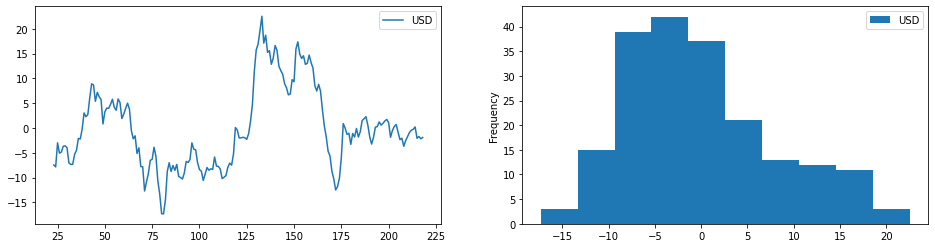

In [90]:
# 24か月
ma24 = df_historical.USD.rolling(24).mean() # 移動平均
diff_m24 = (df_historical.USD - ma24) / ma24 * 100 # 移動平均乖離率

# 図示
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(16,4))
diff_m24.plot(ax=axes[0], legend=True)
diff_m24.plot.hist(ax=axes[1], legend=True)

ヒストグラムを見ると―15％や20％異常の乖離が発生することは稀なことがわかる。

# 時系列データの基本統計量と前処理

## コレログラム

自己相関係数を縦軸にとり、横軸にラグkを置いたもの

In [92]:
import io
import requests
import statsmodels.api as sm

# 月ごとの旅客機の乗客数データ
url = "http://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df_content = pd.read_csv(io.StringIO(stream.decode("utf-8")))
passengers = df_content["#Passengers"]

In [96]:
# 自己相関
p_acf = sm.tsa.stattools.acf(passengers)
p_acf

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092])

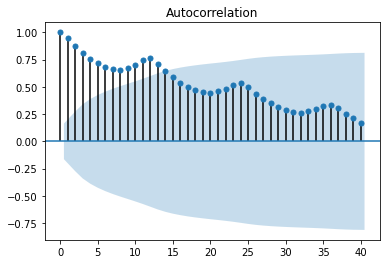

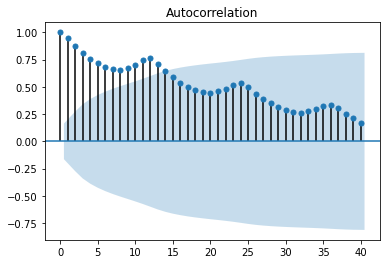

In [98]:
# コレログラムの図示
sm.graphics.tsa.plot_acf(passengers, lags=40)

- ラグがおおきくなるにつれて自己相関係数の値が小さくなる傾向があり、過去にさかのぼるほど現在との相関関係が弱くなっていることが確認できる。

- 図中の青色の帯は95%信頼区間を示しており、帯の外にある値は、有意水準5%で無相関という帰無仮説を棄却し有意である。
    - ラグ14までは自己相関係数は有意であり、相関があることが示唆される。

## 偏自己相関PARCOR, PACF: partial autocorrelation

- ラグ1の自己相関係数はラグ1の積み重ねによる間接的な関係(推移関係)が含まれている。
- 推移関係を排除した自己相関係数を偏自己相関係数という

In [101]:
# 偏自己相関
# olsは最小二乗法による推定を意味する
p_pasf = sm.tsa.stattools.pacf(passengers, nlags=40)
p_pasf

c:\Users\masayoshi\Documents\03.study\06.Machine Learning\12_time_series_data\venv\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


array([ 1.00000000e+00,  9.54677042e-01, -2.65277317e-01,  5.54695472e-02,
        1.08856215e-01,  8.11257853e-02,  4.12540544e-03,  1.56169553e-01,
        1.03708330e-01,  2.88781439e-01,  2.06918048e-01,  2.41129704e-01,
       -1.58004984e-01, -7.18324604e-01, -8.94806410e-02,  2.21605913e-01,
        1.34622533e-01,  1.15615719e-01,  1.94829396e-01,  9.66561845e-02,
       -2.02158680e-01, -9.36381005e-02, -3.45594572e-01, -1.06170206e-01,
        2.77804723e-01,  5.87815922e-02,  9.86624045e-03,  2.37687367e-01,
        9.40568218e-02, -1.47505422e-01, -1.88609051e-01, -2.52801158e-01,
       -2.57153789e-01, -1.40349613e-01,  1.88263087e-01,  1.30686258e-01,
        5.23902189e-01,  6.91426442e-01,  9.91163921e-01,  3.71021065e+01,
       -8.85334119e-01])

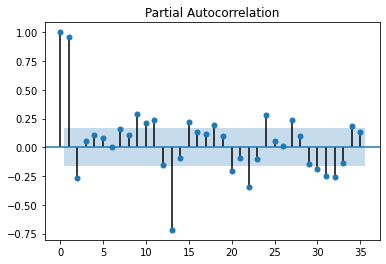

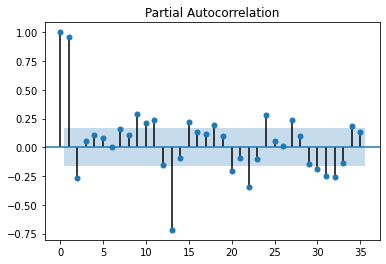

In [103]:
# 偏自己相関のコレログラム
sm.graphics.tsa.plot_pacf(passengers, lags=35)

- ラグ1で大きな正の相関がある
    - 先月の乗客数が多ければ今月の乗客数が多くなる傾向
- ラグ13で大きな負の相関がある
    - 12か月の季節周期がある

## 定常と非定常


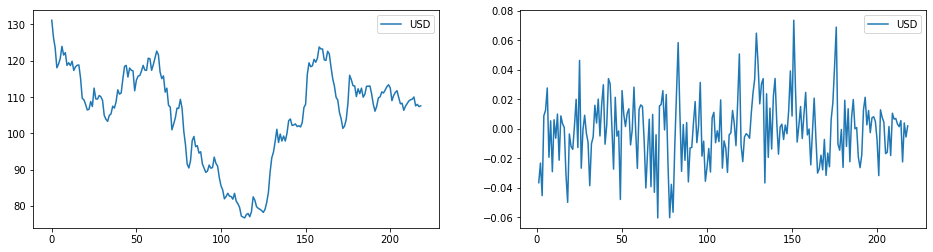

In [106]:
# USDデータの原系列
df_historical_logdiff = (1 + df_historical.USD.pct_change()).apply(np.log)

fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(16,4))
# 原系列
df_historical.USD.plot(ax=axes[0], legend=True)
# 対数差分系列
df_historical_logdiff.plot(ax=axes[1], legend=True)

- 対数差分系列をとると非定常な原系列を定常な状態に近付けることができる。
- 定常か非定常かはADF検定を行って判断する。